In [1]:
import math
from io import BytesIO

import tensorflow as tf
import numpy as np
import PIL.Image
import IPython.display
import matplotlib.pyplot as plt

%matplotlib inline

## Preparing the data

Data comes in CSV format, where the first column is the label and the others represent a pixel intensity value between 0 and 255, in cells 0 to 783 (allowing for 784 cells or 28 x 28).

Going to load the labels and pixel values into a list, then create a numpy array for them both.

In [2]:
import csv

fh = open('./data/train.csv')
reader = csv.reader(fh)

# Skip header line
_ = next(reader)

In [3]:
labels = []
imgs = []

for line in reader:
    label, img = line[0], line[1:]
    
    labels.append(label)
    imgs.append(img)

In [4]:
len(imgs[0])

784

In [5]:
imgs = np.uint8(imgs)

In [6]:
print(imgs.shape)

(42000, 784)


In [7]:
def show_digit(a, fmt='png'):
    """To do: optionally show label here."""
    a = a.reshape((28, 28))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [8]:
show_digit(imgs[500])

In [9]:
show_digit(imgs[305])

In [10]:
labels = np.uint8(labels)
labels_sample = labels[:1000]
labels_sample[:5]

array([1, 0, 1, 4, 0], dtype=uint8)

Next, converting the labels into a one hot matrix and normalising the pixel values by dividing by the max.

In [11]:
C = tf.constant(10, name='c')
one_hot_matrix = tf.one_hot(labels, C, axis=1, dtype=tf.uint8)

sess = tf.Session()
labels_one_hot = sess.run(one_hot_matrix)
sess.close()

imgs_norm = imgs / 255

In [12]:
assert labels_one_hot.shape == (len(labels), 10)

In [13]:
dev_set_size = int(len(imgs_norm) * 0.2)

training_imgs_X = imgs_norm[dev_set_size:,:]
training_labels_y = labels_one_hot[dev_set_size:,:]

dev_imgs_X = imgs_norm[:dev_set_size,:]
dev_labels_y = labels_one_hot[:dev_set_size,:]

In [14]:
print("Training X shape: ", training_imgs_X.shape)
print("Training y shape: ", training_labels_y.shape)

print("Dev X shape: ", dev_imgs_X.shape)
print("Dev y shape: ", dev_labels_y.shape)

Training X shape:  (33600, 784)
Training y shape:  (33600, 10)
Dev X shape:  (8400, 784)
Dev y shape:  (8400, 10)


## Simple Neural Net

Going to build a simple 3-layer NN and see what sort of performance I get. Setting the mini batch size to 64.

In [15]:
num_digits = 10
learning_rate = 0.0001
num_epochs = 1000
print_every = 100
mini_batch_size = 64
sample_size = 2000

In [19]:
def get_random_minibatches(X, Y, mini_batch_size=64, seed=0):
    """Return a list of minibatches in format ([x...], [y...])."""
    np.random.seed(seed)
    m = X.shape[0]
    
    # Create a random list of numbers
    permutations = list(np.random.permutation(m))
    shuffled_X = X[permutations,:]
    shuffled_Y = Y[permutations,:]
    
    num_mini_batches = math.floor(m / mini_batch_size)
    
    for i in range(num_mini_batches):
        start_pos = i * mini_batch_size
        end_pos = start_pos + mini_batch_size
        
        mini_batch_X = shuffled_X[start_pos:end_pos,:]
        mini_batch_Y = shuffled_Y[start_pos:end_pos,:]
        
        yield (mini_batch_X, mini_batch_Y)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[m - mini_batch_size :,:]
        mini_batch_Y = shuffled_Y[m - mini_batch_size :,:]
        yield (mini_batch_X, mini_batch_Y)

Create a simple 3 layer network, by initialising weight vectors and defining simple cost function.

In [98]:
def init_params(input_size, num_layers=3, num_nodes=256):
    params = {}
    
    previous_layer_size = input_size
    for layer in range(1, num_layers):
        weights = tf.get_variable('W{0}'.format(layer), [previous_layer_size, num_nodes], initializer=tf.contrib.layers.xavier_initializer(seed=1))
        bias = tf.get_variable('b{0}'.format(layer), [1, num_nodes], initializer=tf.zeros_initializer())
        params['W{0}'.format(layer)] = weights
        params['b{0}'.format(layer)] = bias
        previous_layer_size = num_nodes

    out = tf.get_variable('out', [previous_layer_size, 10], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    bout = tf.get_variable('bout', [1, 10], initializer=tf.zeros_initializer())
    
    params.update({'out': out, 'bout': bout})
                   
    return params

In [99]:
def forward_prop(X, params, num_layers):
    previous_layer = X
    
    for layer in range(1, num_layers):   
        # Hidden fully connected layer with 256 neurons
        Z = tf.matmul(previous_layer, params['W{0}'.format(layer)]) + params['b{0}'.format(layer)]
        previous_layer = tf.nn.relu(Z)

    # Output fully connected layer with a neuron for each class
    out_layer = tf.add(tf.matmul(previous_layer, params['out']), params['bout'])
    
    return out_layer

In [100]:
def get_cost(out_layer, Y, params, l2_lambda=0):
    logits = out_layer
    labels = Y

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    for key, val in params.items():
        if key.startswith('W') or key == 'out':
            cost += l2_lambda * tf.nn.l2_loss(val)
    
    return cost

In [101]:
def train_model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs=100, print_every=10, num_layers=3, l2_lambda=0):
    m = X_train.shape[0]

    tf.reset_default_graph()

    with tf.Session() as sess:
        X = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, Y_train.shape[1]), name='Y')

        costs = []
        num_mini_batches = m / mini_batch_size

        params = init_params(X_train.shape[1], num_layers=num_layers)

        logits = forward_prop(X, params, num_layers=num_layers)

        cost = get_cost(logits, Y, params, l2_lambda=l2_lambda)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        init = tf.global_variables_initializer()
        
        sess.run(init)

        for epoch in range(1, num_epochs + 1):
            epoch_cost = 0.

            minibatches = get_random_minibatches(X_train, Y_train, mini_batch_size)
            
            for X_mini, y_mini in minibatches:
                _, batch_cost = sess.run([optimizer, cost], feed_dict={X: X_mini, Y: y_mini})
                epoch_cost += batch_cost / num_mini_batches

            if epoch % print_every == 0:
                print("Cost at {0} epochs is {1}".format(epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per 5)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save params
        params = sess.run(params)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return params

Cost at 10 epochs is 0.31448265266418457
Cost at 20 epochs is 0.12275664329528808
Cost at 30 epochs is 0.06387345504760743
Cost at 40 epochs is 0.03622783446311951
Cost at 50 epochs is 0.02206498664617538
Cost at 60 epochs is 0.01433120214939117
Cost at 70 epochs is 0.00982926371693611
Cost at 80 epochs is 0.007055454492568969
Cost at 90 epochs is 0.005244057685136796
Cost at 100 epochs is 0.004007218718528748


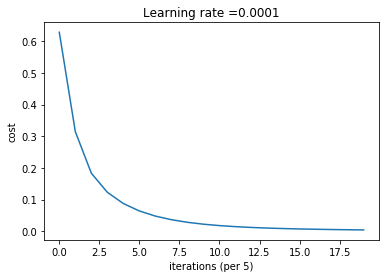

Train Accuracy: 0.9385
Test Accuracy: 0.888929


In [94]:
# Try it on a sample
parameters = train_model(training_imgs_X[:sample_size,:], training_labels_y[:sample_size,:], dev_imgs_X, dev_labels_y)

Cost at 10 epochs is 0.08301672039997017
Cost at 20 epochs is 0.027002864043849245
Cost at 30 epochs is 0.006765189715051315
Cost at 40 epochs is 0.0012021945392882022
Cost at 50 epochs is 0.00016747965083725697
Cost at 60 epochs is 1.9053406206104396e-05
Cost at 70 epochs is 1.9051057296878982e-06
Cost at 80 epochs is 1.8469939395481826e-07
Cost at 90 epochs is 2.3362884449897267e-08
Cost at 100 epochs is 6.247843265395599e-09


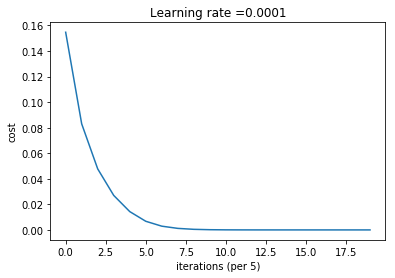

Train Accuracy: 1.0
Test Accuracy: 0.974405


In [102]:
parameters = train_model(training_imgs_X, training_labels_y, dev_imgs_X, dev_labels_y)

Can't really beat that for train accuracy! Let's see how the model does on the test data.

In [109]:
def predict(X, parameters, num_layers):
    params = {}
    
    for param in parameters:
        converted = tf.convert_to_tensor(parameters[param])
        params[param] = converted
    
    x = tf.placeholder("float", [None, X.shape[1]])
    
    out_layer = forward_prop(x, params, num_layers)
    p = tf.argmax(out_layer, 1)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [38]:
fh = open('./data/test.csv')
test_reader = csv.reader(fh)

# Skip header line
_ = next(test_reader)

test_imgs = [line for line in test_reader]

test_imgs = np.float32(test_imgs)
test_imgs_norm = test_imgs / 255.

In [111]:
predictions = predict(test_imgs_norm, parameters, num_layers=3)

In [112]:
show_digit(test_imgs[0]), predictions[0]

(None, 2)

In [26]:
def save_predictions(predictions, filepath='output.csv'):
    """Save predictions to an output path."""
    output = open(filepath, 'w')
    output.write(u'ImageId,Label\n')
    [output.write(u'{0},{1}\n'.format(count + 1, pred)) 
        for count, pred in enumerate(predictions)]
    output.close()

In [116]:
save_predictions(predictions)

Achieved 0.97285, which puts me at 919th. Let's see what happens when I add another 2 layers.

Cost at 10 epochs is 0.20724493384361267
Cost at 20 epochs is 0.07069047206640244
Cost at 30 epochs is 0.029948371142148975
Cost at 40 epochs is 0.010436168044805525
Cost at 50 epochs is 0.0037129726372659203
Cost at 60 epochs is 0.002236641701310873
Cost at 70 epochs is 0.0014628027491271492
Cost at 80 epochs is 0.0010065924720838667
Cost at 90 epochs is 0.000715516055934131
Cost at 100 epochs is 0.0005222483812831341


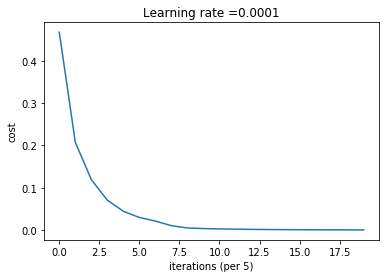

Train Accuracy: 1.0
Test Accuracy: 0.922143


In [117]:
parameters = train_model(training_imgs_X[:sample_size,:], training_labels_y[:sample_size,:], dev_imgs_X, dev_labels_y, num_layers=5)

Cost at 10 epochs is 0.03797345446600095
Cost at 20 epochs is 0.006432536671802936
Cost at 30 epochs is 0.006839779336961714
Cost at 40 epochs is 7.001626531250949e-05
Cost at 50 epochs is 6.809914106079925e-06
Cost at 60 epochs is 4.328754305151149e-07
Cost at 70 epochs is 2.6062829700761767e-08
Cost at 80 epochs is 0.016118488271088836
Cost at 90 epochs is 3.007468850889487e-06
Cost at 100 epochs is 6.211653812978768e-07


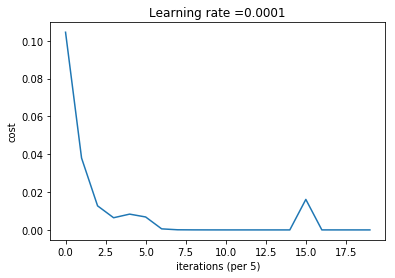

Train Accuracy: 1.0
Test Accuracy: 0.97619


In [119]:
parameters = train_model(training_imgs_X, training_labels_y, dev_imgs_X, dev_labels_y, num_layers=5)

In [120]:
save_predictions(predict(test_imgs_norm, parameters, num_layers=5))

Slightly better. Gets me a score of 0.97357, which gets me to 911 place - about 8 places better than before.

Looks like I'm overfitting, since the training accuracy is 100%, so let's think about:

  * Regularisation (L2 norm, dropout)
  * Maybe data augmentation?
  * Different architecture? CNN etc.

Let's start with regularisation. Regularisation is a technique for encouraging weights to be smaller by basically adding the weights to the cost function. The point of it is to ensure a single weight doesn't get too big, thus overfitting the training data, and therefore we hope it generalises better on the dev/test set. L2 regularisation is simply the sum of the squared weights. Something like:

$\sum\limits_{i=1}^{k} {w_i}^2$

You also provide a "lambda" component that represents how much regularisation you want. A very high lambda, will ensure regularisation has a huge impact. A lambda of 0, will ensure regularisation has no impact. Tensorflow provides a method for implementing L2 regularisation in the cost function in `tf.nn.l2_loss` and would be implemented as follows:

```
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
cost += 0.01 * tf.nn.l2_loss(weights)
```

Note: generally you don't need to regularise the bias term. I have gone back and refactored the `get_cost` method to add l2 reg.

Training model with 0.1 l2
Cost at 100 epochs is 2.156626937866211


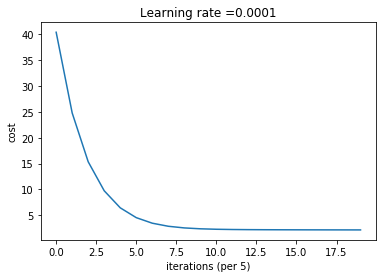

Train Accuracy: 0.782
Test Accuracy: 0.751905
Training model with 0.01 l2
Cost at 100 epochs is 0.7170602397918702


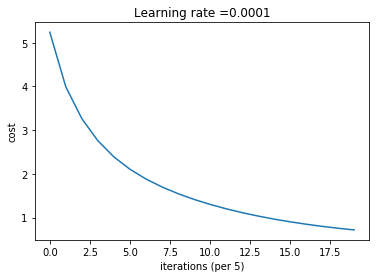

Train Accuracy: 0.998
Test Accuracy: 0.912143
Training model with 0.001 l2
Cost at 100 epochs is 0.27829407882690427


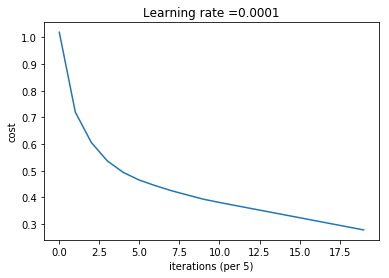

Train Accuracy: 1.0
Test Accuracy: 0.918214
Training model with 0.0001 l2
Cost at 100 epochs is 0.047913573026657115


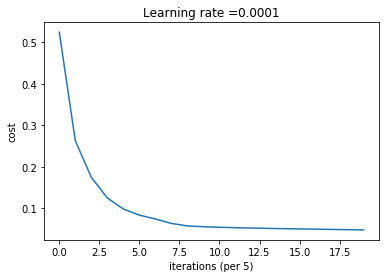

Train Accuracy: 1.0
Test Accuracy: 0.921429


In [121]:
for lambd in [0.1, 0.01, 0.001, 0.0001]:
    print('Training model with {0} l2'.format(lambd))
    train_model(training_imgs_X[:sample_size,:], training_labels_y[:sample_size,:], dev_imgs_X, dev_labels_y, num_layers=5, num_epochs=100, print_every=100, l2_lambda=lambd)

None of these seem to help much. See how it goes training longer.

Cost at 10 epochs is 0.7032029866036913
Cost at 20 epochs is 0.5283693423725314
Cost at 30 epochs is 0.4965198655923207
Cost at 40 epochs is 0.4858313919249032
Cost at 50 epochs is 0.48066374903633463
Cost at 60 epochs is 0.47691385581379875
Cost at 70 epochs is 0.4737046388217386
Cost at 80 epochs is 0.47066327293713867
Cost at 90 epochs is 0.46779108847890555
Cost at 100 epochs is 0.46511590492157734


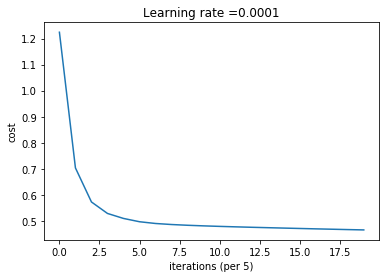

Train Accuracy: 0.976637
Test Accuracy: 0.961429


In [166]:
parameters = train_model(training_imgs_X, training_labels_y, dev_imgs_X, dev_labels_y, num_layers=5, l2_lambda=0.001)

It appears to take much longer to converge and training accuracy has decreased. Seems to have helped with overfitting a lil but hasn't helped with dev accuracy. Let's get drastic and introduce a conv layer with dropout.

### Introducing a conv layer

Conv layers are essentially a tool for performing automated feature engineering, discovering stand out patterns an dd the like in the image content. They can be implemented in Tensorflow using `tf.nn.conv2d`.

In [20]:
def init_conv_params():
    return {
        "W_conv_1": tf.get_variable('W_conv_1', [5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer(seed=1)),
        "b_conv_1": tf.get_variable('b_conv_1', [32], initializer=tf.zeros_initializer()),
        "W_conv_2": tf.get_variable('W_conv_2', [5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=1)),
        "b_conv_2": tf.get_variable('b_conv_2', [64], initializer=tf.zeros_initializer()),
        "W_fc_1": tf.get_variable('W_fc_1', [7*7*64, 1024], initializer=tf.contrib.layers.xavier_initializer(seed=1)),
        "b_fc_1": tf.get_variable('b_fc_1', [1024], initializer=tf.zeros_initializer()),
        "out": tf.get_variable('out', [1024, 10], initializer=tf.contrib.layers.xavier_initializer(seed=1)),
        "b_out": tf.get_variable('b_out', [10], initializer=tf.zeros_initializer())
    }


def conv_2d_block(X, W, b, strides=1):
    """Question to ask: what are strides?"""
    # Strides refers to the "stride of the sliding window for each dimension of input"
    x = tf.nn.conv2d(X, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return x


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


def get_conv_net(X, params, keep_prob=1):
    # Need to be reshaped from flattened format for some reason?
    # Tensorflow is 4d: (height, width, num channels, dataset size)
    x = tf.reshape(X, shape=[-1, 28, 28, 1])
    
    conv1 = conv_2d_block(x, params['W_conv_1'], params['b_conv_1'])
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv_2d_block(conv1, params['W_conv_2'], params['b_conv_2'])
    conv2 = maxpool2d(conv2, k=2)
    
    # Need to flatten out the output for the fully connected layers
    fc1 = tf.reshape(conv2, [-1, params['W_fc_1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, params['W_fc_1']), params['b_fc_1'])
    fc1 = tf.nn.relu(fc1)
    
    # Apply Dropout in fully-connected layer
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, params['out']), params['b_out'])
    
    return out

In [21]:
def train_conv_model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs=100, print_every=10, num_layers=3, l2_lambda=0):
    m = X_train.shape[1]

    tf.reset_default_graph()

    with tf.Session() as sess:
        X = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, Y_train.shape[1]), name='Y')

        costs = []
        num_mini_batches = m / mini_batch_size

        params = init_conv_params()

        logits = get_conv_net(X, params)

        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        init = tf.global_variables_initializer()
        
        sess.run(init)

        for epoch in range(1, num_epochs + 1):
            epoch_cost = 0.

            minibatches = get_random_minibatches(X_train, Y_train, mini_batch_size)

            for X_mini, y_mini in minibatches:
                _, batch_cost = sess.run([optimizer, cost], feed_dict={X: X_mini, Y: y_mini})
                
                epoch_cost += batch_cost / num_mini_batches

            if epoch % print_every == 0:
                print("Cost at {0} epochs is {1}".format(epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per 5)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save params
        params = sess.run(params)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return params

Cost at 10 epochs is 0.3624011527518838
Cost at 20 epochs is 0.11228126222837947
Cost at 30 epochs is 0.04099553449041381
Cost at 40 epochs is 0.018816368017649774
Cost at 50 epochs is 0.007563068493440444
Cost at 60 epochs is 0.004865524187988165
Cost at 70 epochs is 0.003205338452600551
Cost at 80 epochs is 0.00156282571118268
Cost at 90 epochs is 0.0010892895943656257
Cost at 100 epochs is 0.0008153396210756759


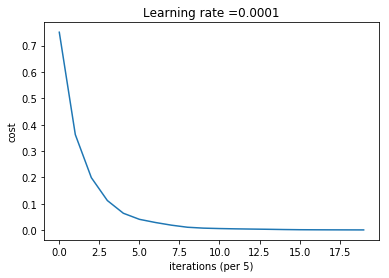

Train Accuracy: 1.0
Test Accuracy: 0.957381
CPU times: user 28.2 s, sys: 3.96 s, total: 32.1 s
Wall time: 32.3 s


In [23]:
%time parameters = train_conv_model(training_imgs_X[:sample_size,:], training_labels_y[:sample_size,:], dev_imgs_X, dev_labels_y)

Try a larger learning rate.

Cost at 10 epochs is 0.006599791581999054
Cost at 20 epochs is 0.0003377885534843829
Cost at 30 epochs is 0.0001439501834191069
Cost at 40 epochs is 8.426290659539222e-05
Cost at 50 epochs is 5.5511425244378404e-05
Cost at 60 epochs is 3.906836334454984e-05
Cost at 70 epochs is 2.866276421702089e-05
Cost at 80 epochs is 2.1658890638755853e-05
Cost at 90 epochs is 1.6690439382245483e-05
Cost at 100 epochs is 1.3068660852083239e-05


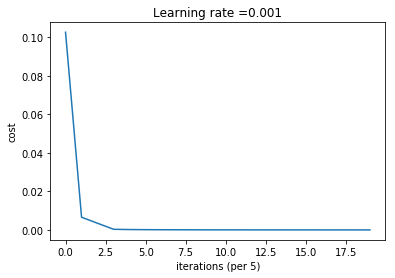

Train Accuracy: 1.0
Test Accuracy: 0.964286
CPU times: user 27.9 s, sys: 3.79 s, total: 31.6 s
Wall time: 32.2 s


In [44]:
%time parameters = train_conv_model(training_imgs_X[:sample_size,:], training_labels_y[:sample_size,:], dev_imgs_X, dev_labels_y, learning_rate=0.001)

Seems like a definite winner. See how we go across the whole dataset with the original params.

Cost at 10 epochs is 0.733139244250345
Cost at 20 epochs is 0.21832646887597412
Cost at 30 epochs is 0.0664490667642468
Cost at 40 epochs is 0.0021667147496685544
Cost at 50 epochs is 0.010084308976715592
Cost at 60 epochs is 0.0004159638124130134
Cost at 70 epochs is 4.387909781283216e-05
Cost at 80 epochs is 0.0004728077797429912
Cost at 90 epochs is 5.9751413667514296e-05
Cost at 100 epochs is 6.328074911587024e-06


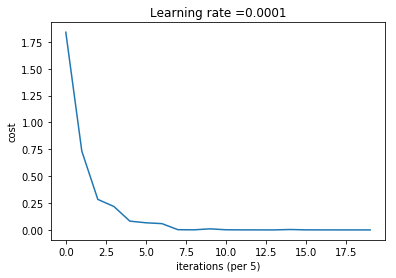

Train Accuracy: 0.999999
Test Accuracy: 0.989167
CPU times: user 7min 27s, sys: 1min 11s, total: 8min 39s
Wall time: 8min 46s


In [25]:
%time parameters = train_conv_model(training_imgs_X, training_labels_y, dev_imgs_X, dev_labels_y)

In [41]:
def predict(X, parameters):
    params = {}
    
    for param in parameters:
        converted = tf.convert_to_tensor(parameters[param])
        params[param] = converted
    
    x = tf.placeholder(tf.float32, [None, X.shape[1]])

    logits = get_conv_net(X, params)
    p = tf.argmax(logits, 1)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [42]:
predictions = predict(test_imgs_norm, parameters)

In [43]:
save_predictions(predictions, 'conv_predictions.csv')

Holy shit!

You advanced 494 places on the leaderboard!
Your submission scored 0.99042, which is an improvement of your previous score of 0.97357.

See how it goes with a few more epochs, I guess?

Cost at 10 epochs is 0.7360387145094945
Cost at 20 epochs is 0.2235015389005823
Cost at 30 epochs is 0.03316289574983173
Cost at 40 epochs is 0.0021176074183589513
Cost at 50 epochs is 0.00236182703485369
Cost at 60 epochs is 0.00023037544919513714
Cost at 70 epochs is 0.05609880298142834
Cost at 80 epochs is 0.0003106203886914311
Cost at 90 epochs is 3.592700170930642e-05
Cost at 100 epochs is 3.791416230022255e-06
Cost at 110 epochs is 3.6082084199385277e-07
Cost at 120 epochs is 4.77445324998961e-08
Cost at 130 epochs is 1.642168649588736e-08
Cost at 140 epochs is 1.0187527837197356e-08
Cost at 150 epochs is 0.7674576961011215


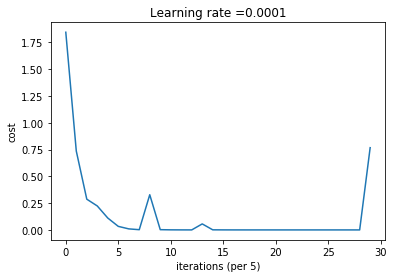

Train Accuracy: 0.998778
Test Accuracy: 0.984643
CPU times: user 11min 4s, sys: 1min 46s, total: 12min 51s
Wall time: 13min 3s


In [48]:
%time parameters = train_conv_model(training_imgs_X, training_labels_y, dev_imgs_X, dev_labels_y, num_epochs=150)

So the learning rate needs to come down a little bit after 27 iterations or so?